# Assignment 4

Your task is to write code for learning the parameters of an aircraft encounter model from data.
Using the provided airplane trajectories you will:

1.  Learn an initial scene model
2.  Learn an uncorrelated dynamics model

The file [flights.txt](#) is formatted identically to the previous assignment.
Use the provided data to learn your models.

Turn in your completed julia notebook, and any associated code files you wrote to Coursework.
Do not use any external code or Julia packages other than those used in the class materials.

## Milestone One: Set Up

In [2]:
using AA120Q
plotlyjs()

Plots.PlotlyJSBackend()

### Load the Dataset

Now, you will need to load all the the datasets provided by initial.txt and transition.txt. The commands and outputs are provided below. 

In [2]:
list_datasets()

2-element Array{AbstractString,1}:
 "large"
 "small"

In [3]:
flights = get_dataset("small")
flights

,id,A,C1,C2
1,1,4,2,2
2,2,4,2,2
3,3,2,2,2


## Milestone Two: Initial Conditions Model

Here we demonstrate how to implement a simple model.

We define the encounter with just the intitial speeds $v1$ and $v2$, and $u1$ and $u2$. We can consider the two planes as points in an xy-plane moving towards each other. 

You need to develop your own initial conditions model, then write your code here to implement the data structure for the probabilty distribution. We have provided the following starter code and would like you to use the speeds and positions of the aircraft at t=40s and go back linearly to determine intial positions at t=0s, using the given speeds for both aircraft at 40s. 

# make new picture

This simple model thus defines a probability distribution as follows:

$$P(\Delta x, \Delta y, \Delta u, \Delta v)$$

First, use categorical distributions for everything (**Pull Raw Data**), and discretize continuous variables into bins (**Discretize Dataset**).

Then train a discrete Bayesian network over the discrete dataset (**Fit Distributions**).
We will repeat this process for the Dynamics Model.

### Pulling the Raw Data

In [1]:
#Get the number of rows needed
N = nrow(initial)

#Initializes a data frame to store the inital conditions
data_initial = DataFrame(
    u1=Array(Float64, N),
    u2=Array(Float64, N),
    v1=Array(Float64, N),
    v2=Array(Float64, N)
)

j = 1
flightids = flights[:id]
for id in 1 : nrow(initial)
    j = findnext(flightids, id, j)
    
    data_initial[id, :x1] = flights[j,:x1]
    data_initial[id, :y1] = flights[j,:y1]
    data_initial[id, :x2] = flights[j,:x2]
    data_initial[id, :y2] = flights[j,:y2]
    data_initial[id, :u1] = flights[j,:u1]
    data_initial[id, :u2] = flights[j,:u2]
    data_initial[id, :v1] = flights[j,:v1]
    data_initial[id, :v2] = flights[j,:v2]
end

data_initial[1:3,:]

LoadError: [91mUndefVarError: nrow not defined[39m

### Discretize Dataset

Is there any means of tuning the discretization of the data? 

In [1]:
using Discretizers

D = Dict{Symbol,LinearDiscretizer}()
D[:v] = LinearDiscretizer(Float64[0,30,60,90,120,150,180]) # [m/s]
D[:u] = LinearDiscretizer(Float64[150,365,915,1520,3800]) # [m/s]

data_initial[:u1] = encode(D[:u], data_initial[:u1])
data_initial[:u2] = encode(D[:u], data_initial[:u2])
data_initial[:v1] = encode(D[:v], data_initial[:v1])
data_initial[:v2] = encode(D[:v], data_initial[:v2])

ncategories = [4, 2, 2, nlabels(D[:v]), nlabels(D[:v]), nlabels(D[:u]), nlabels(D[:u])]

data_initial[1:3,:]

INFO: Precompiling module Discretizers.


LoadError: UndefVarError: data_initial not defined

###  Fit Distributions

In [3]:
using BayesNets

params = GreedyHillClimbing(ScoreComponentCache(data_initial), max_n_parents=3, 
prior=UniformPrior())
bn_initial = fit(DiscreteBayesNet, data_initial, params, ncategories=ncategories)

LoadError: ArgumentError: Module BayesNets not found in current path.
Run `Pkg.add("BayesNets")` to install the BayesNets package.

### Sampling

#### Sample from Initial to get Initial Scene

We now have to implement `Base.rand(model)` which should generate Encounters.


`sample_initial` should take in an EncounterModel and produce the airspace class, the aircraft categories, and two AircraftStates

In [1]:
struct DiscretizedBayesNet
    dbn::DiscreteBayesNet
    discs::Dict{Symbol, LinearDiscretizer}
end

LoadError: [91mUndefVarError: DiscreteBayesNet not defined[39m

In [2]:
function Base.rand(bn::DiscretizedBayesNet)
    sample = rand(model.dbn) # pull from discrete Bayes net
    
    # convert discrete samples to continuous samples
    for (sym, disc) in bn.discs
        sample[sym] = decode(disc, sample[sym]) 
    end

    return sample
end

LoadError: [91mUndefVarError: DiscretizedBayesNet not defined[39m

#### Sample Traces

`sample_transition` takes a model and two aircraft states and returns the actions for each aircraft at that timestep.

In [3]:
function AA120Q.sample_transition(s1::AircraftState, s2::AircraftState, model::DemoEncounterModel, params::EncounterSimParams)
    
    v = rand(model.transition) # [du, dv]
    a1 = AircraftAction(v[1], v[2])

    v = rand(model.transition) # [du, dv]
    a2 = AircraftAction(v[1], v[2])
    
    (a1, a2)
end

enc = rand(model, DEFAULT_SIM_PARAMS)
plot_encounter(enc)

LoadError: UndefVarError: AA120Q not defined

## Milestone Three: Dynamics Model

Now lets train a simple uncorrelated dynamics model. It represents:

$$P(\dot{u}, \dot{v} \mid \Delta x, \Delta y, \Delta u, \Delta v)$$

We will train:

$$P(\dot{u}, \dot{v}, \Delta x, \Delta y, \Delta u, \Delta v)$$

Again, we would like to improve the model like how we did with the intial conditions model. Here are a few ways of improving the given model:

1. Add additional three conditional variables: acceleration, climbrate, and turnrate
             
2. Include other variables (current altitude, aircraft type, etc.)

Develop your own dynamics model of probability dsitribution using a Discrete Bayesian.

Use the following code as a starting point. You have until week 5 to work on it.

### Fit Distributions

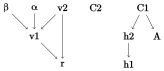

In [7]:
using BayesNets

params = GreedyHillClimbing(ScoreComponentCache(data_initial), max_n_parents=3, prior=UniformPrior())
bn_initial = fit(DiscreteBayesNet, data_initial, params, ncategories=ncategories)

### Pull Raw Data

What new variables can be added?

In [9]:
M = 2*51*N # 2 aircraft per run, 51 frame-deltas per run

data_transition = DataFrame(
    du=Array(Float64, M), # vertical accel [m/s2]
    dv=Array(Float64, M), # horizontal accel [m/s2]
)

j = 1
i = 0
traceids = traces[:id]
for id in 1 : N
    j = findnext(traceids, id, j)
    
    for k in 1 : 51
        i += 1
        data_transition[i, :du] = traces[j + k, :u1] - traces[j + k - 1, :u1]
        data_transition[i, :dv] = traces[j + k, :v1] - traces[j + k - 1, :v1]

        i += 1
        data_transition[i, :du] = traces[j + k, :u2] - traces[j + k - 1, :u2]
        data_transition[i, :dv] = traces[j + k, :v2] - traces[j + k - 1, :v2]
    end
end

data_transition[1:3,:]

,dv,dh,dψ
1,0.0,-198.37739324832364,0.7296650000000007
2,-1.4572300000000098,0.0,2.8514299999999935
3,0.0,-198.37739324832364,0.7296649999999989


### Fit Distributions

In [ ]:
using BayesNets

params = GreedyHillClimbing(ScoreComponentCache(data_transition), max_n_parents=3, 
prior=UniformPrior())
bn_transition = fit(DiscreteBayesNet, data_transition, params, ncategories=ncategories)

###  Sampling

In [16]:
function Base.rand(bn::DiscretizedBayesNet, evidence::Assignment)
    
    # discretize the assignment
    for (sym, disc) in bn.discs
        evidence[sym] = encode(disc, evidence[sym]) 
    end
    
    sample = rand(model.dbn, evidence) # pull from discrete Bayes net
    
    # convert discrete samples to continuous samples
    for (sym, disc) in bn.discs
        sample[sym] = decode(disc, sample[sym]) 
    end

    return sample
end

3-element Array{Float64,1}:
  -0.64761
 -41.7968 
   1.2444 

In [6]:
rand(transition, Assignment(:Δx => 1.0, :Δy => -1.5, :Δu => 2.0, :Δv => 3.0))

LoadError: UndefVarError: transition not defined

### Saving

In [18]:
using HDF5, JLD
JLD.save(Pkg.dir("AA120Q", "data", "myencountermodel.jld"), "initial", bn_initial, 
                                 "initdisc", D,
                                 "transition", transition,)